In [1]:
# Importing necessary libraries
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import torch
import subprocess

# Install ultralytics
subprocess.run(["pip", "install", "ultralytics"])
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# File paths
img_directory = "/content/drive/MyDrive/images"
data_csv_path = "/content/drive/MyDrive/faces.csv"
results_directory = "/content/drive/MyDrive/FacesOutput"

# Load the dataset
face_data = pd.read_csv(data_csv_path)

# EDA
print(face_data.head())
print(face_data.info())
print(face_data.describe())


     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB
None
             width       height           x0           y0           x1  \
count  3350.000000  3350.000000  3350.000000  3350.000000  3350.000000   
mean    967.96716

In [6]:
# Plot distribution of image widths and heights using Plotly
width_dist_fig = px.histogram(face_data, x='width', nbins=50, title='Distribution of Image Widths',
                              labels={'width': 'Image Width'}, template='plotly_dark')
width_dist_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
width_dist_fig.show()

height_dist_fig = px.histogram(face_data, x='height', nbins=50, title='Distribution of Image Heights',
                               labels={'height': 'Image Height'}, template='plotly_dark')
height_dist_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
height_dist_fig.show()


In [7]:
# Plot distribution of bounding box coordinates using Plotly
x0_dist_fig = px.histogram(face_data, x='x0', nbins=50, title='Distribution of X0 Coordinates',
                           labels={'x0': 'X0 Coordinate'}, template='plotly_dark')
x0_dist_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
x0_dist_fig.show()

y0_dist_fig = px.histogram(face_data, x='y0', nbins=50, title='Distribution of Y0 Coordinates',
                           labels={'y0': 'Y0 Coordinate'}, template='plotly_dark')
y0_dist_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
y0_dist_fig.show()

x1_dist_fig = px.histogram(face_data, x='x1', nbins=50, title='Distribution of X1 Coordinates',
                           labels={'x1': 'X1 Coordinate'}, template='plotly_dark')
x1_dist_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
x1_dist_fig.show()

y1_dist_fig = px.histogram(face_data, x='y1', nbins=50, title='Distribution of Y1 Coordinates',
                           labels={'y1': 'Y1 Coordinate'}, template='plotly_dark')
y1_dist_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
y1_dist_fig.show()


In [8]:
# Calculate additional columns for analysis
face_data['bbox_width'] = face_data['x1'] - face_data['x0']
face_data['bbox_height'] = face_data['y1'] - face_data['y0']
face_data['bbox_area'] = face_data['bbox_width'] * face_data['bbox_height']
face_data['aspect_ratio'] = face_data['bbox_width'] / face_data['bbox_height']

# Plot 1: Bounding Box Area Distribution
bbox_area_fig = px.histogram(face_data, x='bbox_area', nbins=50, title='Distribution of Bounding Box Areas',
                             labels={'bbox_area': 'Bounding Box Area'}, template='plotly_dark')
bbox_area_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
bbox_area_fig.show()

# Plot 2: Aspect Ratio Distribution
aspect_ratio_fig = px.histogram(face_data, x='aspect_ratio', nbins=50, title='Distribution of Bounding Box Aspect Ratios',
                                labels={'aspect_ratio': 'Aspect Ratio (Width/Height)'}, template='plotly_dark')
aspect_ratio_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
aspect_ratio_fig.show()

# Plot 3: Heatmap for Bounding Box Positions
bbox_heatmap_fig = px.density_heatmap(face_data, x='x0', y='y0', title='Heatmap of Bounding Box Positions',
                                      labels={'x0': 'X0 Coordinate', 'y0': 'Y0 Coordinate'}, template='plotly_dark')
bbox_heatmap_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
bbox_heatmap_fig.show()

# Plot 4: Scatter Plot for Bounding Box Width vs Height
bbox_scatter_fig = px.scatter(face_data, x='bbox_width', y='bbox_height', title='Bounding Box Width vs Height',
                              labels={'bbox_width': 'Bounding Box Width', 'bbox_height': 'Bounding Box Height'},
                              template='plotly_dark')
bbox_scatter_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
bbox_scatter_fig.show()

# Plot 5: Scatter Plot for Image Width vs Height
image_scatter_fig = px.scatter(face_data, x='width', y='height', title='Image Width vs Height',
                                labels={'width': 'Image Width', 'height': 'Image Height'}, template='plotly_dark')
image_scatter_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
image_scatter_fig.show()


In [9]:
bbox_3d_fig = px.scatter_3d(face_data, x='x0', y='y0', z='bbox_area',
                            color='bbox_area', title='3D Scatter Plot of Bounding Box Positions and Area',
                            labels={'x0': 'X0 Coordinate', 'y0': 'Y0 Coordinate', 'bbox_area': 'Bounding Box Area'},
                            template='plotly_dark')
bbox_3d_fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
bbox_3d_fig.show()


In [ ]:
# Convert bounding box coordinates to YOLO format (normalized x_center, y_center, width, height)
def convert_to_yolo_format(row):
    inv_width = 1. / row['width']
    inv_height = 1. / row['height']
    x_center = (row['x0'] + row['x1']) / 2.0
    y_center = (row['y0'] + row['y1']) / 2.0
    box_width = row['x1'] - row['x0']
    box_height = row['y1'] - row['y0']
    x_center = x_center * inv_width
    box_width = box_width * inv_width
    y_center = y_center * inv_height
    box_height = box_height * inv_height
    return x_center, y_center, box_width, box_height

face_data[['x_center', 'y_center', 'box_width', 'box_height']] = face_data.apply(
    convert_to_yolo_format, axis=1, result_type='expand')


In [ ]:
# Split the dataset into train and validation sets
training_data, validation_data = train_test_split(face_data, test_size=0.2, random_state=42)


In [ ]:
# Create YOLO annotation files
yolo_annotations_dir = os.path.join(results_directory, 'annotations')
os.makedirs(yolo_annotations_dir, exist_ok=True)

for index, record in face_data.iterrows():
    annotation_file_path = os.path.join(yolo_annotations_dir, record['image_name'].replace('.jpg', '.txt'))
    with open(annotation_file_path, 'w') as file:
        file.write(f"0 {record['x_center']} {record['y_center']} {record['box_width']} {record['box_height']}\n")


In [ ]:
# Function to create YOLO annotation files
def generate_yolo_annotations(data_frame, annotations_directory):
    os.makedirs(annotations_directory, exist_ok=True)
    for index, record in data_frame.iterrows():
        annotation_file_path = os.path.join(annotations_directory, record['image_name'].replace('.jpg', '.txt'))
        with open(annotation_file_path, 'w') as file:
            file.write(f"0 {record['x_center']} {record['y_center']} {record['box_width']} {record['box_height']}\n")

# Create YOLO annotation files for training and validation sets
train_labels_dir = os.path.join(results_directory, 'train', 'labels')
val_labels_dir = os.path.join(results_directory, 'val', 'labels')

generate_yolo_annotations(training_data, train_labels_dir)
generate_yolo_annotations(validation_data, val_labels_dir)


In [ ]:
# Image preprocessing
def process_images(image_names, source_directory, destination_directory):
    os.makedirs(destination_directory, exist_ok=True)
    for image_name in image_names:
        image_path = os.path.join(source_directory, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            destination_path = os.path.join(destination_directory, image_name)
            cv2.imwrite(destination_path, image)

train_images_directory = os.path.join(results_directory, 'train', 'images')
val_images_directory = os.path.join(results_directory, 'val', 'images')

process_images(training_data['image_name'].tolist(), img_directory, train_images_directory)
process_images(validation_data['image_name'].tolist(), img_directory, val_images_directory)

# Verify annotation files
print("Sample train annotations:")
print(os.listdir(train_labels_dir)[:5])

print("Sample validation annotations:")
print(os.listdir(val_labels_dir)[:5])


Sample train annotations:
['00002698.txt', '00000453.txt', '00000239.txt', '00000831.txt', '00002260.txt']
Sample validation annotations:
['00003348.txt', '00000597.txt', '00001195.txt', '00003187.txt', '00002796.txt']


In [ ]:
yolo_model_instance = YOLO('yolov8n.yaml')


In [ ]:
# Define the data.yaml file content dynamically
category_names = ['face']
data_yaml_content = f"""
train: {train_images_directory}
val: {val_images_directory}
nc: {len(category_names)}
names: {category_names}
"""

# Save the data.yaml file
data_yaml_file_path = os.path.join(results_directory, 'data.yaml')
with open(data_yaml_file_path, 'w') as file:
    file.write(data_yaml_content)


In [ ]:
# Train the model
yolo_model_instance.train(data=data_yaml_file_path, epochs=50, imgsz=640)


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/FacesOutput/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

train: Scanning /content/drive/MyDrive/FacesOutput/train/labels.cache... 1852 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1852/1852 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/FacesOutput/val/labels.cache... 585 images, 0 backgrounds, 0 corrupt: 100%|██████████| 585/585 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.34G      3.119      3.913       3.89         23        640: 100%|██████████| 116/116 [01:12<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


                   all        585        585    0.00408      0.303     0.0039    0.00124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.46G      2.738      3.007      3.141         28        640: 100%|██████████| 116/116 [00:59<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]


                   all        585        585      0.115      0.267     0.0795     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.46G      2.402      2.502      2.851         21        640: 100%|██████████| 116/116 [00:58<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.45it/s]

                   all        585        585      0.144      0.117     0.0553     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.37G      2.182      2.243      2.635         20        640: 100%|██████████| 116/116 [00:58<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]

                   all        585        585      0.368      0.409      0.346      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.37G      1.964      2.097      2.427         25        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]

                   all        585        585       0.47      0.453      0.444      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.37G      1.848      1.967      2.324         23        640: 100%|██████████| 116/116 [00:56<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.60it/s]

                   all        585        585      0.394      0.572      0.404      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.37G      1.771      1.922      2.249         20        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]

                   all        585        585       0.47      0.579      0.505      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.37G      1.712      1.855      2.196         20        640: 100%|██████████| 116/116 [00:55<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.61it/s]

                   all        585        585      0.386      0.588      0.456      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G      1.658      1.786      2.149         26        640: 100%|██████████| 116/116 [00:57<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]

                   all        585        585      0.413      0.615      0.495       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G      1.625      1.745      2.112         19        640: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


                   all        585        585      0.428      0.544       0.47      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.37G      1.564      1.696      2.071         23        640: 100%|██████████| 116/116 [00:55<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]


                   all        585        585      0.436      0.607      0.515      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.37G      1.537      1.645      2.027         33        640: 100%|██████████| 116/116 [00:54<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all        585        585      0.418      0.612      0.461       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G      1.509      1.638      2.004         16        640: 100%|██████████| 116/116 [00:56<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.61it/s]

                   all        585        585      0.397      0.662      0.459      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G      1.493       1.63      1.982         26        640: 100%|██████████| 116/116 [00:55<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


                   all        585        585      0.412      0.607      0.495      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.37G      1.477      1.589      1.953         24        640: 100%|██████████| 116/116 [00:56<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]

                   all        585        585      0.431      0.583      0.488      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.37G      1.435      1.536      1.928         23        640: 100%|██████████| 116/116 [00:56<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.28it/s]

                   all        585        585      0.402      0.577      0.457       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G      1.423      1.558       1.92         24        640: 100%|██████████| 116/116 [00:55<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]

                   all        585        585        0.5       0.53      0.562       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.37G      1.399      1.501      1.895         28        640: 100%|██████████| 116/116 [00:56<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]

                   all        585        585      0.517       0.55      0.575      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.37G      1.401      1.475      1.905         25        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]

                   all        585        585      0.469       0.62      0.565      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.37G      1.386      1.462      1.877         23        640: 100%|██████████| 116/116 [00:56<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.58it/s]

                   all        585        585        0.5      0.567       0.55       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.37G      1.375      1.463      1.874         25        640: 100%|██████████| 116/116 [00:56<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        585        585      0.532      0.595      0.588      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.37G       1.35      1.431      1.848         22        640: 100%|██████████| 116/116 [00:57<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]

                   all        585        585        0.5      0.639       0.61       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.37G      1.293      1.374      1.791         22        640: 100%|██████████| 116/116 [00:55<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        585        585      0.563      0.622      0.627      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.37G      1.311      1.382      1.798         18        640: 100%|██████████| 116/116 [00:56<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]

                   all        585        585      0.605      0.632      0.656      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.37G      1.311      1.377       1.81         21        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]

                   all        585        585      0.523      0.631      0.623      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.37G        1.3      1.359      1.795         29        640: 100%|██████████| 116/116 [00:56<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]

                   all        585        585      0.577      0.588      0.644      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.37G      1.283      1.331      1.783         22        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        585        585      0.601      0.569      0.619      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.37G      1.292      1.376      1.792         20        640: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        585        585      0.595      0.587      0.627       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.37G      1.265      1.342      1.775         24        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

                   all        585        585       0.59      0.591      0.633      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.37G      1.251       1.29      1.769         23        640: 100%|██████████| 116/116 [00:55<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        585        585      0.651      0.581       0.67      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.37G      1.237      1.281      1.743         32        640: 100%|██████████| 116/116 [00:56<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        585        585      0.558      0.648      0.644       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.37G      1.229      1.256      1.732         31        640: 100%|██████████| 116/116 [00:56<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        585        585      0.633      0.564      0.666      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.37G      1.225      1.255      1.737         26        640: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]

                   all        585        585      0.672      0.564      0.681      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.37G      1.228      1.258       1.73         23        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]

                   all        585        585      0.648      0.591       0.68      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.37G      1.187      1.236      1.695         30        640: 100%|██████████| 116/116 [00:55<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]

                   all        585        585      0.579      0.629      0.674      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.37G      1.191      1.234      1.694         30        640: 100%|██████████| 116/116 [00:55<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]

                   all        585        585      0.656      0.571       0.67      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.37G      1.176      1.198      1.684         24        640: 100%|██████████| 116/116 [00:54<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]

                   all        585        585      0.706        0.6      0.727      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.37G      1.194        1.2      1.684         26        640: 100%|██████████| 116/116 [00:56<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]

                   all        585        585      0.619      0.598      0.689      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.37G      1.171      1.179      1.675         23        640: 100%|██████████| 116/116 [00:54<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all        585        585      0.639      0.641      0.721      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.37G      1.174      1.179      1.672         26        640: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]

                   all        585        585      0.719      0.564      0.702      0.475


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.37G      1.032     0.9674       1.62         12        640: 100%|██████████| 116/116 [00:56<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]

                   all        585        585      0.584      0.659      0.727      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G      1.008     0.8773      1.602         11        640: 100%|██████████| 116/116 [00:52<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]

                   all        585        585      0.661      0.632      0.747      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.37G      0.986     0.8499      1.578         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        585        585      0.698      0.607      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.37G     0.9599     0.8331      1.559         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]

                   all        585        585      0.693      0.617      0.754      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.37G     0.9566     0.8126      1.548         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        585        585      0.733        0.6      0.762      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.37G     0.9495     0.8061      1.537         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]

                   all        585        585      0.733        0.6      0.769      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.37G     0.9318     0.7896      1.535         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        585        585      0.716      0.624      0.768      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.37G     0.9417     0.8066      1.531         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        585        585        0.7      0.624      0.773      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.9037     0.7751      1.504         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]

                   all        585        585      0.694      0.644      0.776      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.37G     0.9219     0.7871      1.524         12        640: 100%|██████████| 116/116 [00:54<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]

                   all        585        585      0.742      0.619      0.784      0.556



50 epochs completed in 0.954 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


                   all        585        585      0.733      0.626      0.784      0.557
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa68cf1d6f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00003348.jpg: 448x640 3 faces, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


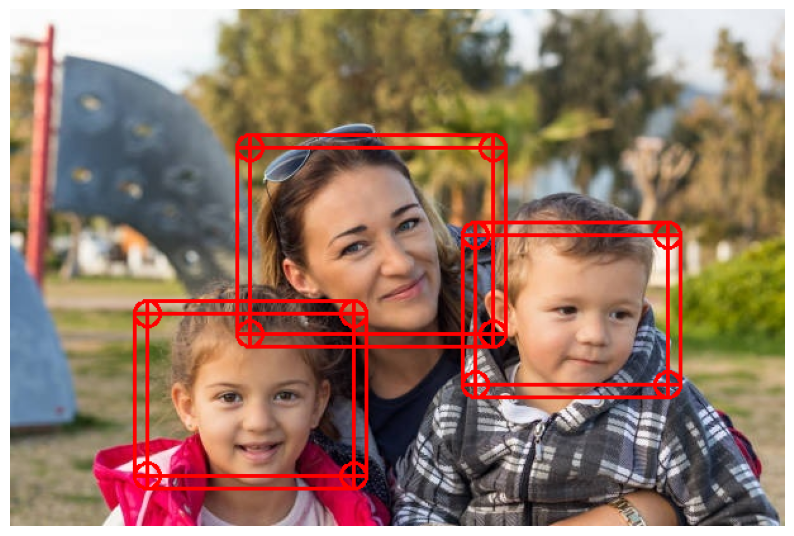


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00000597.jpg: 384x640 2 faces, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


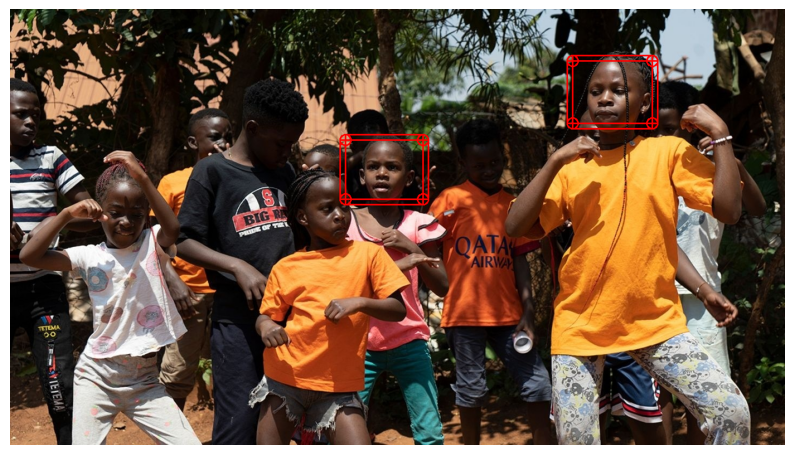


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00001195.jpg: 448x640 1 face, 10.1ms
Speed: 4.1ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


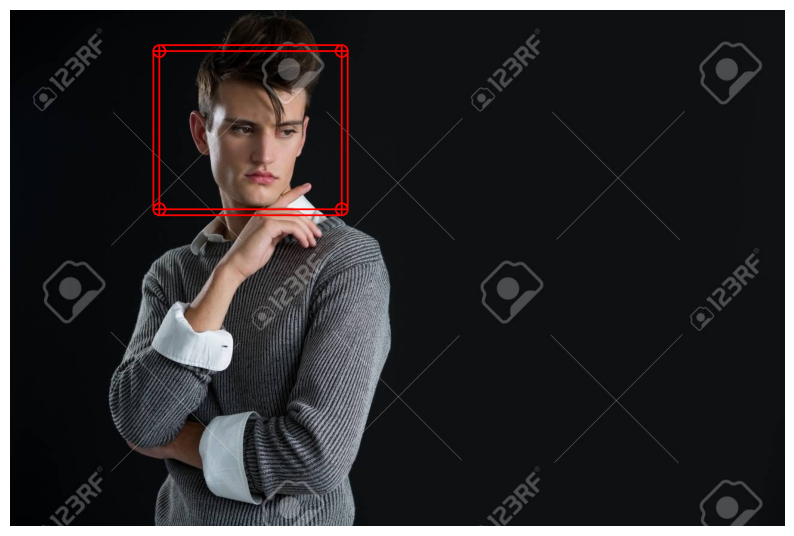


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00003187.jpg: 448x640 1 face, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


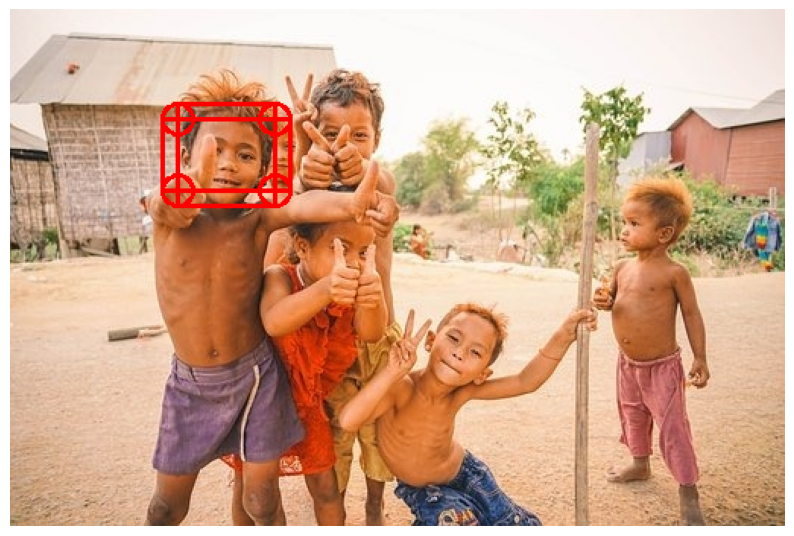


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00002796.jpg: 640x640 2 faces, 11.8ms
Speed: 6.5ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


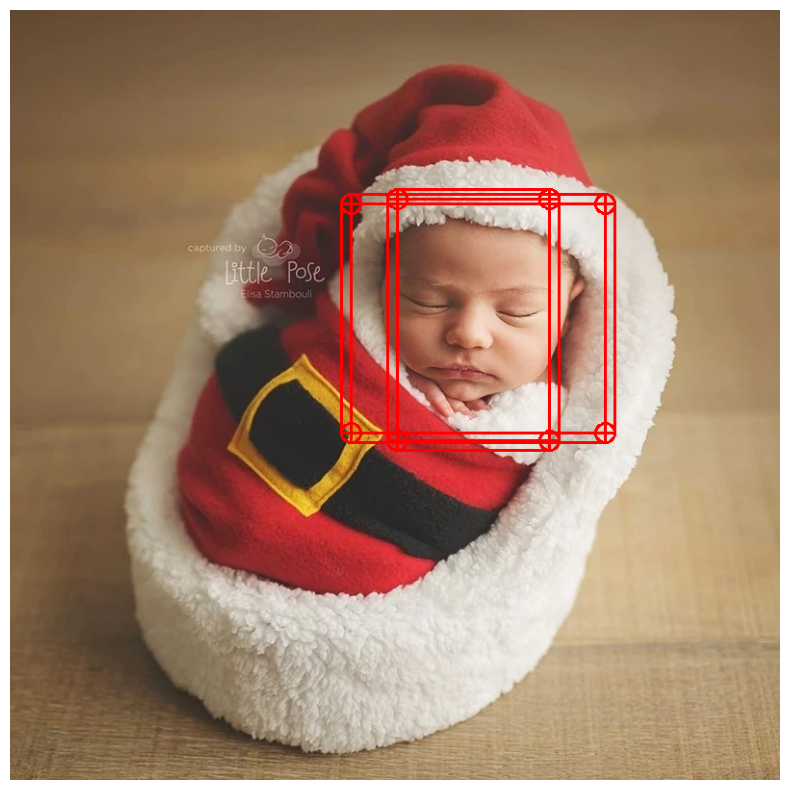


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00001732.jpg: 640x448 1 face, 36.8ms
Speed: 21.8ms preprocess, 36.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


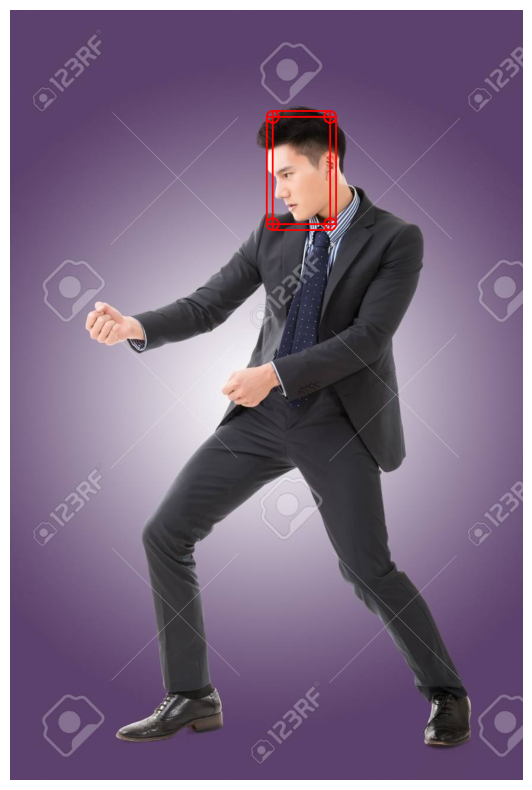


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00001956.jpg: 480x640 1 face, 10.6ms
Speed: 3.8ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


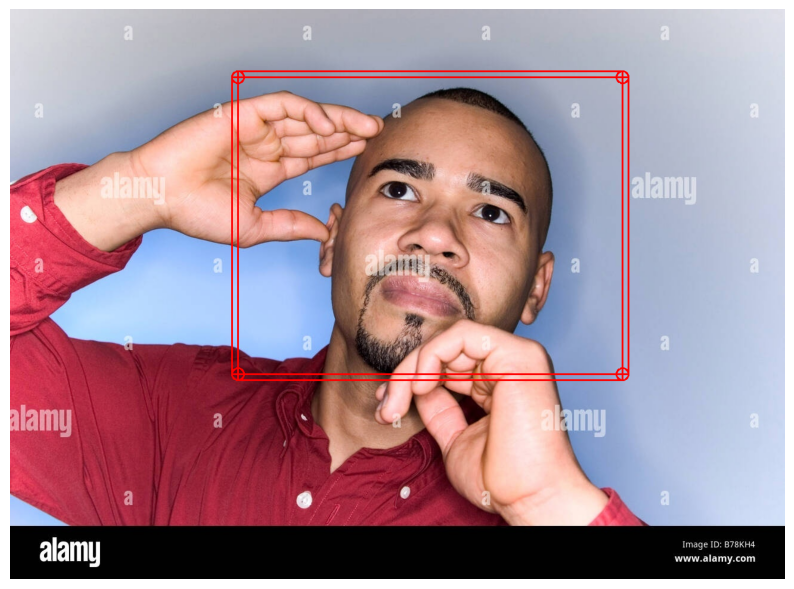


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00002817.jpg: 448x640 1 face, 9.6ms
Speed: 3.8ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


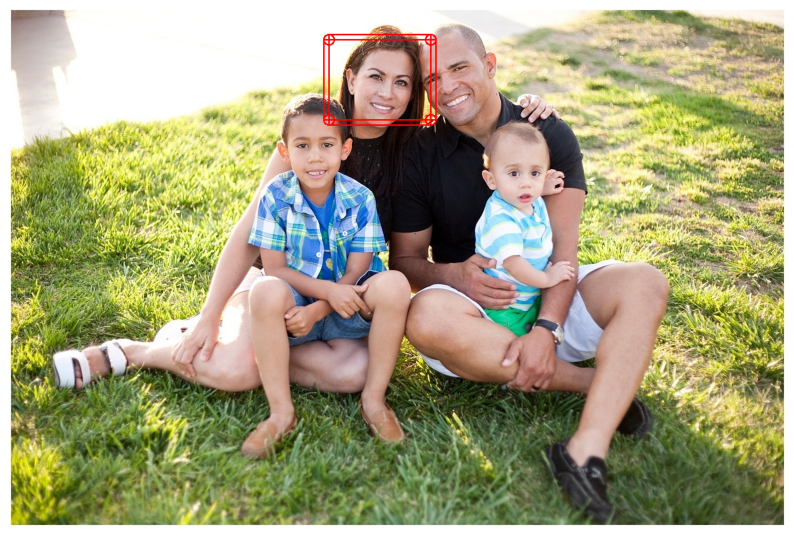


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00002478.jpg: 448x640 2 faces, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


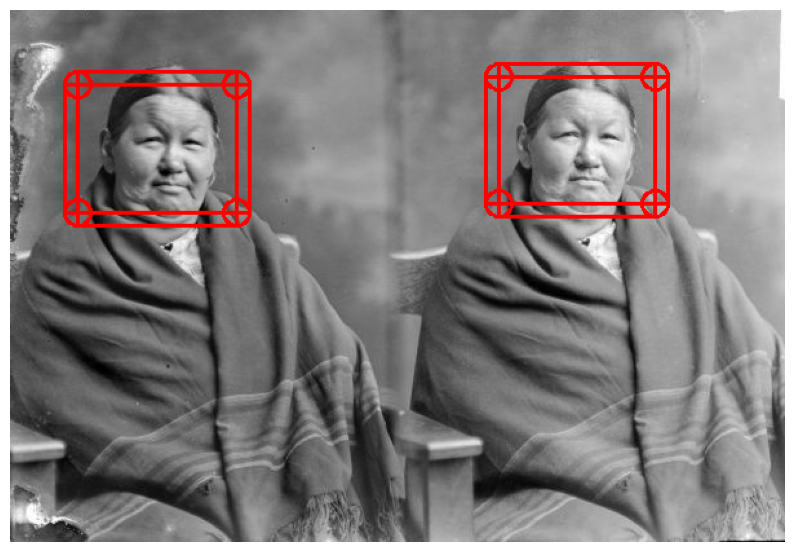


image 1/1 /content/drive/MyDrive/FacesOutput/val/images/00000377.jpg: 448x640 2 faces, 16.7ms
Speed: 3.5ms preprocess, 16.7ms inference, 4.2ms postprocess per image at shape (1, 3, 448, 640)


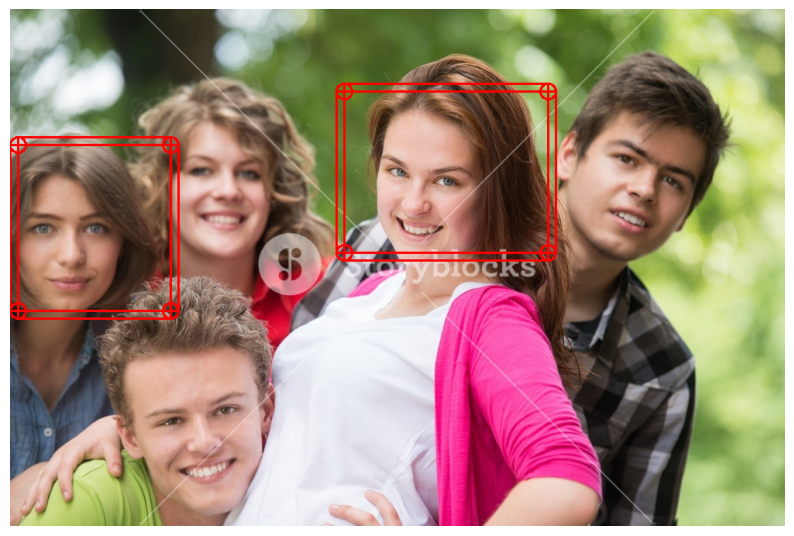

Process completed. Outputs are stored in: /content/drive/MyDrive/FacesOutput


In [ ]:
# Function to draw rounded rectangle
def draw_curved_rectangle(image, top_left, bottom_right, rect_color, line_thickness, corner_radius):
    x1, y1 = top_left
    x2, y2 = bottom_right
    image = cv2.rectangle(image, (x1 + corner_radius, y1), (x2 - corner_radius, y2), rect_color, line_thickness)
    image = cv2.rectangle(image, (x1, y1 + corner_radius), (x2, y2 - corner_radius), rect_color, line_thickness)
    image = cv2.circle(image, (x1 + corner_radius, y1 + corner_radius), corner_radius, rect_color, line_thickness)
    image = cv2.circle(image, (x2 - corner_radius, y1 + corner_radius), corner_radius, rect_color, line_thickness)
    image = cv2.circle(image, (x1 + corner_radius, y2 - corner_radius), corner_radius, rect_color, line_thickness)
    image = cv2.circle(image, (x2 - corner_radius, y2 - corner_radius), corner_radius, rect_color, line_thickness)
    return image

# Display 10 sample images with detection results
def show_detection_samples(model_instance, images_directory, num_samples=10):
    sampled_images = os.listdir(images_directory)[:num_samples]
    for image_name in sampled_images:
        image_path = os.path.join(images_directory, image_name)
        detection_results = model_instance(image_path)[0]  # Get the first (and only) Results object
        image = cv2.imread(image_path)
        for bbox in detection_results.boxes.xyxy.cpu().numpy():  # x1, y1, x2, y2
            x1, y1, x2, y2 = map(int, bbox)
            image = draw_curved_rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2, 10)  # Red color, thickness 2, radius 10
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

show_detection_samples(yolo_model_instance, val_images_directory)

print("Process completed. Outputs are stored in:", results_directory)



image 1/1 /content/drive/MyDrive/temp_479ab519f1134c1d9dd46530d59f25ea.jpg: 480x640 1 face, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


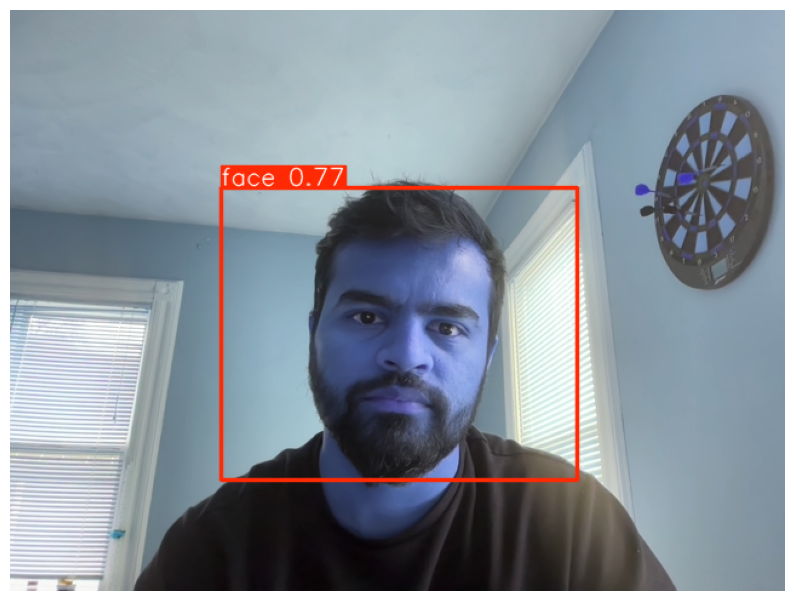

Annotated image saved to: /content/drive/MyDrive/test_images_output/annotated_photo.jpg


In [ ]:
# Import necessary libraries
import os
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
test_image_path = "/content/drive/MyDrive/temp_479ab519f1134c1d9dd46530d59f25ea.jpg"
output_test_dir = "/content/drive/MyDrive/test_images_output"  # Directory to save the output
os.makedirs(output_test_dir, exist_ok=True)

# Load the trained YOLOv8 model
yolo_model = YOLO("/content/runs/detect/train3/weights/best.pt")  # Path to your trained weights

# Run inference on the test image
results = yolo_model(test_image_path)

# Access the first result
result = results[0]  # Extract the first (and only) result from the list

# Visualize the detection using the plot method
annotated_image = result.plot()  # Get the annotated image as a NumPy array

# Convert the NumPy array to an image
image = Image.fromarray(annotated_image)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

# Save the annotated image
output_image_path = os.path.join(output_test_dir, "annotated_photo.jpg")
image.save(output_image_path)

print(f"Annotated image saved to: {output_image_path}")
